In [ ]:
import os
os.chdir("/content/drive/MyDrive/MADE/work/РусАгро/")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import math
import time
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import numpy as np
from  scipy import stats
import scipy
import cv2

import torch.optim as optim
import torchvision.models as models
from tqdm.notebook import tqdm
from torch.nn import functional as fnn

np.random.seed(1)
torch.manual_seed(1)
random.seed(1)
import pandas as pd
import PIL
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
HSIZE = 588
WSIZE = 1280


In [ ]:
class Args:
  def __init__(self): #(data_path, epoch, batch_siz, image_size, learning_rate, weight_deca, learning_rate, learning_rate_gamma, weight_bce, load, output_dir)
    self.epochs = 2
    self.batch_size = 32
    self.lr= 3e-4
    self.weight_decay= 1e-6
    self.learning_rate=None
    self.learning_rate_gamma=None
    self.weight_bce=1
    self.load=None
    self.output_dir="/content/drive/MyDrive/MADE/Project/RACNN_models/"
    self.data_dir ="./data_preprocessed_python/"# "/content/drive/MyDrive/MADE/Project/train/physionet.org/"
args = Args()   

In [ ]:
geom = {}
geom['IMG-20211020-WA0006.jpg'] = [[0, 443], [165, 350], [1079, 350], [1280, 437]]
geom['IMG-20211020-WA0007.jpg'] = [[0, 414], [173, 333], [1098, 339], [1280,437]]
geom['IMG-20211020-WA0008.jpg'] = [[0, 409], [194, 317], [1112, 325], [1280, 415]] 
geom['IMG-20211021-WA0000.jpg'] = [[0, 442], [194, 316], [1108, 310], [1280, 390]] 
geom['IMG-20211021-WA0001.jpg'] = [[0, 392], [156, 310], [1080, 314], [1280, 416]] 
geom['IMG-20211021-WA0002.jpg'] = [[0, 380], [154, 294], [1084, 294], [1280, 394]]
geom['IMG-20211022-WA0000.jpg'] = [[0, 502], [154, 418], [1078, 420], [1280, 518]] 
geom['IMG-20211022-WA0001.jpg'] = [[0, 524], [188, 372 ], [1086, 352], [1280, 434]] 
geom['IMG-20211022-WA0002.jpg'] = [[0, 452], [162, 372], [1080, 364], [1280, 476]] 

In [ ]:
import glob
class ChanDataset(Dataset):
    def __init__(self, root, transforms, files):
        super(ChanDataset, self).__init__()
        self.root = root 
        self.filenames = []
        self.transforms = transforms
        self.labels = []
        self.root = root
          
        # path = os.path.join(root, f"*.jpg")
        # print(path)  
        # files = glob.glob(path)
       
        
        print(len(files))
        lens = []
        for i, filename in enumerate(files):
             print(filename)
             image = cv2.imread(filename)
             #print(self.image_names[idx])
             print(image.shape)
             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
             f1 = WSIZE/image.shape[1]
             f2 = HSIZE/image.shape[0]
             image = cv2.resize(image, None, fx=f1, fy=f2, interpolation=cv2.INTER_AREA)
             print(image.shape)
             if i == 0:
                 self.columns = image
             else:    
                 self.columns = np.concatenate((self.columns, image), axis = 1)
             self.filenames.append(filename[10 :])    
        print(self.filenames)    

                 
    def get_levels(self, ind, x):
        rect = geom[self.filenames[ind]]
        for i in range(3):
            x1 = rect[i][0]
            y1 = rect[i][1]
            x2 = rect[i + 1][0]
            y2 = rect[i + 1][1]
            #print(x, x1, x2)
            if (x >= x1) and (x <= x2):
              k = (y2 - y1)/(x2 - x1)
              level = k * x + (y1 - k * x1)
         
        #levels = [2 if y > level + 30 else 1 if y > level - 5 else 0 for y in range(588, 0, -1)]     
        levels = [0 if y > level - 5 else 1  for y in range(588, 0, -1)]     
        return levels     

          
    def __getitem__(self, idx):
        sample = {}
        sample['column'] = torch.FloatTensor(self.columns[ 588 :: -1, idx].copy());
        sample['level'] = torch.LongTensor(np.array(self.get_levels(idx // 1280, idx % 1280)))
        sample['x'] = idx
        #print('***')
        #print(sample['column'].shape)
        #print(len(sample['level']))
        #print( sample['level'])
        return sample

    def __len__(self):
        #print(self.columns.shape[1])
        return (self.columns.shape[1])

In [ ]:
 path = os.path.join('./img/img/',  f"*.jpg")
 print(path)  
 files = glob.glob(path)
 train_dataset = ChanDataset('./img/img/', [],  files[0:4])

./img/img/*.jpg
4
./img/img/IMG-20211021-WA0001.jpg
(588, 1280, 3)
(588, 1280, 3)
./img/img/IMG-20211021-WA0002.jpg
(588, 1280, 3)
(588, 1280, 3)
./img/img/IMG-20211021-WA0000.jpg
(588, 1280, 3)
(588, 1280, 3)
./img/img/IMG-20211020-WA0007.jpg
(588, 1280, 3)
(588, 1280, 3)
['IMG-20211021-WA0001.jpg', 'IMG-20211021-WA0002.jpg', 'IMG-20211021-WA0000.jpg', 'IMG-20211020-WA0007.jpg']


In [ ]:
sample = train_dataset.__getitem__(20)
print(sample)

{'column': tensor([[ 77.,  76.,  74.],
        [ 69.,  68.,  66.],
        [ 74.,  73.,  71.],
        ...,
        [196., 199., 214.],
        [196., 199., 214.],
        [196., 199., 214.]]), 'level': tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 

In [ ]:
 class ChanNet(torch.nn.Module): 
   def __init__(self,  hidden_size):
       super().__init__()
       self.rnn = nn.LSTM(3, hidden_size, bidirectional = True, batch_first = True)
       self.fc = nn.Linear(hidden_size * 2, 2)
       self.dropout = nn.Dropout(0.2)
       
   def forward(self, src):
      # print(src.shape)
       #src = [batch size, seq_len, input_size
       outputs, (hidden, c) = self.rnn(src) 
       predictions = self.fc(self.dropout(outputs))
 
       return predictions 

In [ ]:
EMBEDDING_SIZE = 100
def get_model():
  model = ChanNet(EMBEDDING_SIZE)
  return model

model = get_model()  

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.1)

model.apply(init_weights)

ChanNet(
  (rnn): LSTM(3, 100, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=200, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
from sklearn.model_selection import KFold 
from sklearn.metrics import f1_score, accuracy_score


kf = KFold(n_splits=8, random_state=135, shuffle=True)
split = kf.split(files)
for ind_train, ind_test in  split:
    break
train_dataset = ChanDataset('./img/img/',[], np.array(files)[ind_train])
val_dataset = ChanDataset('./img/img/', [],np.array(files)[ind_test])

train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                    pin_memory=True, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)

7
./img/img/IMG-20211021-WA0001.jpg
(588, 1280, 3)
(588, 1280, 3)
./img/img/IMG-20211021-WA0002.jpg
(588, 1280, 3)
(588, 1280, 3)
./img/img/IMG-20211021-WA0000.jpg
(588, 1280, 3)
(588, 1280, 3)
./img/img/IMG-20211020-WA0008.jpg
(588, 1280, 3)
(588, 1280, 3)
./img/img/IMG-20211020-WA0006.jpg
(588, 1280, 3)
(588, 1280, 3)
./img/img/IMG-20211022-WA0002.jpg
(588, 1280, 3)
(588, 1280, 3)
./img/img/IMG-20211022-WA0001.jpg
(588, 1280, 3)
(588, 1280, 3)
['IMG-20211021-WA0001.jpg', 'IMG-20211021-WA0002.jpg', 'IMG-20211021-WA0000.jpg', 'IMG-20211020-WA0008.jpg', 'IMG-20211020-WA0006.jpg', 'IMG-20211022-WA0002.jpg', 'IMG-20211022-WA0001.jpg']
2
./img/img/IMG-20211020-WA0007.jpg
(588, 1280, 3)
(588, 1280, 3)
./img/img/IMG-20211022-WA0000.jpg
(588, 1280, 3)
(588, 1280, 3)
['IMG-20211020-WA0007.jpg', 'IMG-20211022-WA0000.jpg']


In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 3e-4)

In [ ]:
criterion = nn.CrossEntropyLoss()#ignore_index=TAG_PAD_IDX)

In [ ]:
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in tqdm(iterator):
        #print(batch['column'])
        text = batch['column'].to(device)
        levels = batch['level']
        #print(text)

        optimizer.zero_grad()

        # text shape: (sent len, batch size)

        predictions = model(text).cpu()

        # predictions shape: (sent len, batch size, output dim)
        # tags shape: (sent len, batch size)

        predictions = predictions.view(-1, predictions.shape[-1])
        levels = levels.view(-1)

        # predictions shape: (sent len * batch size, output dim)
        # tags shape: (sent len * batch size)

        loss = criterion(predictions, levels)

        #acc = categorical_accuracy(predictions, tags, tag_pad_idx)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        #epoch_acc += acc.item()

    return epoch_loss / len(iterator)#, epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for batch in tqdm(iterator):
            text = batch['column'].to(device)
            levels = batch['level']

            predictions = model(text).cpu()

            predictions = predictions.view(-1, predictions.shape[-1])
            levels = levels.view(-1)

            loss = criterion(predictions, levels)

            #acc = categorical_accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
           # epoch_acc += acc.item()

    return epoch_loss / len(iterator)#, epoch_acc / len(iterator)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

def calculate_prediction(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    preds = []
    real = []

    mask_right = np.zeros((1280, 588))
    mask_pred = np.zeros((1280, 588))

    with torch.no_grad():
        for batch in tqdm(iterator):
            text = batch['column'].to(device)
            levels = batch['level']
            xcoord = batch['x']

            predictions = model(text).cpu()

            predictions1 = predictions.view(-1, predictions.shape[-1])
            levels1 = levels.view(-1)

            predictions2 = predictions.argmax(axis = 2)
            #print(predictions2[0])

            preds.extend(predictions)
            real.extend(levels)

            for k in range(32):
              x = xcoord[k]
              mask_right[x, :] = reversed(levels[k])
              mask_pred[x, :] = reversed(predictions2[k])
              #print(levels[k])

            loss = criterion(predictions1, levels1)

            #acc = categorical_accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
           # epoch_acc += acc.item()


    return epoch_loss / len(iterator), mask_right, mask_pred#, epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 5

#best_valid_loss = float("inf")

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_acc = valid_acc = 0
    train_loss = train(model, train_dataloader, optimizer, criterion)
    valid_loss = evaluate(model, val_dataloader, criterion)

    end_time = time.time()

    #epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "tut1-model.pt")

    #print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%")
    print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%")

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

	Train Loss: 0.258 | Train Acc: 0.00%
	 Val. Loss: 0.183 |  Val. Acc: 0.00%


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

	Train Loss: 0.054 | Train Acc: 0.00%
	 Val. Loss: 0.141 |  Val. Acc: 0.00%


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

	Train Loss: 0.034 | Train Acc: 0.00%
	 Val. Loss: 0.116 |  Val. Acc: 0.00%


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

	Train Loss: 0.034 | Train Acc: 0.00%
	 Val. Loss: 0.137 |  Val. Acc: 0.00%


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

	Train Loss: 0.021 | Train Acc: 0.00%
	 Val. Loss: 0.136 |  Val. Acc: 0.00%


In [ ]:
with open("tut1-model.pt", "rb") as fp:
      best_state_dict = torch.load(fp, map_location="cpu")
      model.load_state_dict(best_state_dict)

1
./img/img/IMG-20211020-WA0007.jpg
(588, 1280, 3)
(588, 1280, 3)
['IMG-20211020-WA0007.jpg']


  0%|          | 0/40 [00:00<?, ?it/s]

(1280, 588)
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


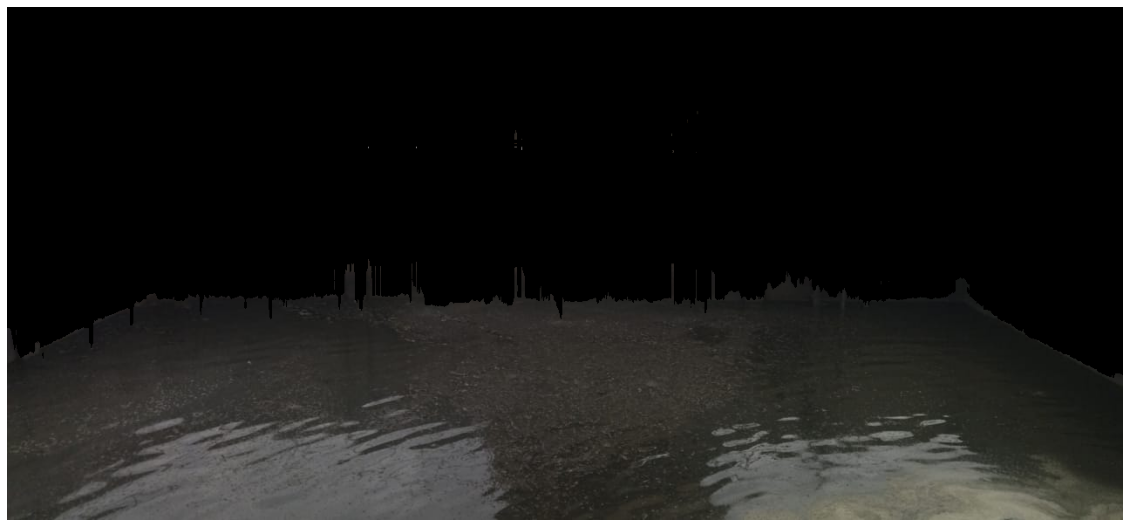

1
./img/img/IMG-20211022-WA0000.jpg
(588, 1280, 3)
(588, 1280, 3)
['IMG-20211022-WA0000.jpg']


  0%|          | 0/40 [00:00<?, ?it/s]

(1280, 588)
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


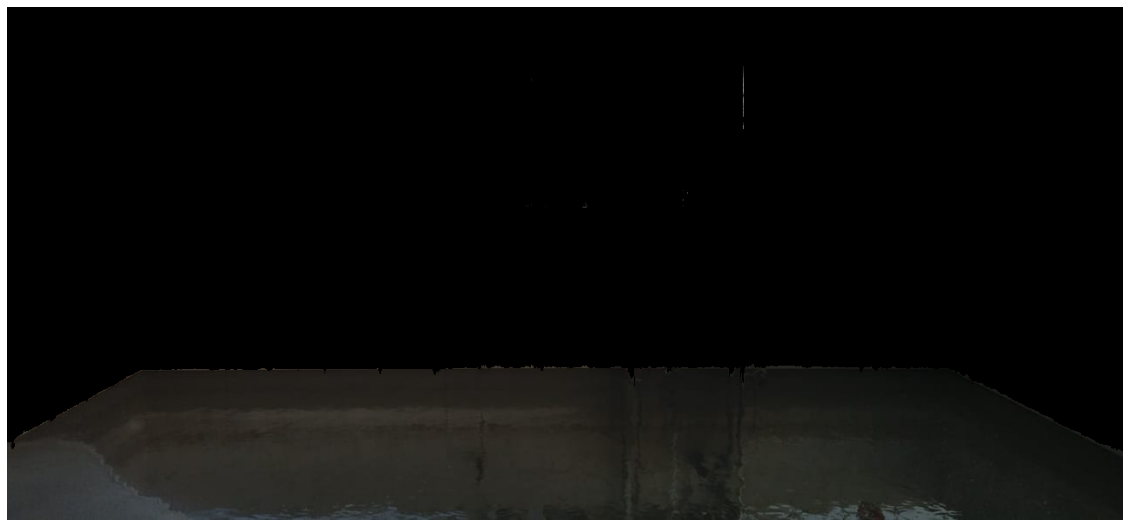

In [ ]:
#def visualize_predictions(filenames):

from matplotlib import pyplot as plt
filenames= np.array(files)[ind_test]
for i in range(len(filenames)):
      #print(file1[10:])
      val_dataset = ChanDataset('./img/img/', [],  filenames[i: i + 1])

          
      val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                                          pin_memory=True, shuffle=False, drop_last=False)
            
      _, mask_right, mask_pred = calculate_prediction(model, val_dataloader, criterion)
      print(mask_right.shape)
      #print(mask)
      image = cv2.imread(filenames[i])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      mask_pred = mask_pred.astype(int)
      print(mask_pred)
      image[mask_pred.T == 1] = (0, 0, 0)
      plt.figure(figsize=(20, 20))
      plt.imshow(image)
      plt.axis('off')
      plt.show()